In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.metrics import mean_squared_error


# Load Datasets

In [2]:
train1 = pd.read_csv('~/Desktop/MusicRec/data/train/train_data_5core.csv',header=None)
test1 = pd.read_csv('~/Desktop/MusicRec/data/test/test_data_with_neg_5core.csv',header = None)

In [3]:
test1.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,1941,250,2561,3,1036,3103,1570,550,3120,1585,...,3020,979,984,1510,487,3048,1513,3567,501,2551
1,1929,255,2563,2052,517,2566,537,2591,1571,2613,...,3508,1973,1974,3517,3010,974,1506,1016,3065,1533
2,1769,255,3072,1030,2054,2057,2058,1547,2570,2573,...,2477,448,3020,972,977,2513,985,3549,3554,506
3,686,310,2,3075,523,3085,3087,3090,1555,1557,...,1484,977,2005,2519,2525,2027,1522,1012,3065,2558
4,872,441,3080,1039,17,28,1566,1573,1585,3128,...,3538,1498,1503,3042,3047,492,1016,3065,3067,508


In [4]:
train1.head()

,0,1,2
0,0,0,5.0
1,1,0,5.0
2,2,0,5.0
3,3,0,5.0
4,4,0,4.0


In [5]:
# We use Pandas pivot method to create index/column data frame and fill the missing play counts with 0.
ratings_df = train1.pivot(
    index=0, 
    columns=1, 
    values=2)
ratings = ratings_df.fillna(0).values

In [6]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):

    validation = np.zeros(ratings.shape)
    train = ratings.copy()

    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
              ratings[user, :].nonzero()[0],
              size=DELETE_RATING_COUNT,
              replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [7]:
train, val = train_test_split(ratings)

In [8]:
# Sparsity of the matrix
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.30%


In [9]:
val.shape

(5541, 3559)

In [10]:
train.shape

(5541, 3559)

# Recommender with SGD 

In [11]:
## RMSE
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [23]:
## SGD 
#We start by creating 2 matrices for the latent features of the users and ratings. 
#For each user, item pair, we calculate the error
#(note we use a simple difference of the existing and predicted ratings). 
#We then update P and Q using Gradient Descent.
class Recommender:
    def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate
  
    def predictions(self, P, Q):
        return np.dot(P.T, Q)
  
    def fit(self, X_train, X_val):
        m, n = X_train.shape

        self.P = 3 * np.random.rand(self.n_latent_features, m)
        self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
        self.train_error = []
        self.val_error = []

        users, items = X_train.nonzero()
    
        for epoch in range(self.n_epochs):
            print(epoch)
            for u, i in zip(users, items):
                error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
                self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
                self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

            train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
            val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
            self.train_error.append(train_rmse)
            self.val_error.append(val_rmse)
        
        return self
  
    def predict(self, X_train):
        y_hat = self.predictions(self.P, self.Q)
        return y_hat

In [24]:
recommender = Recommender().fit(train, val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


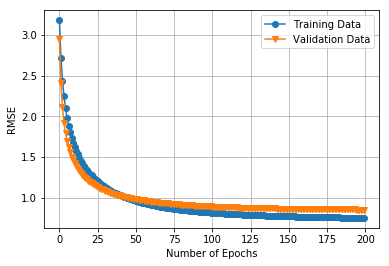

In [14]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [15]:
# Find the itemid in first appear in testset
p = []
for item in list(range(3565)):
    if item not in ratings_df.columns:
        p.append(item)


In [25]:
#Get predicted User-Item Matrix:

rating_predictions = recommender.predict(train)

In [27]:
##Evalutation: HIT@10 metric
hit_at_k = 0



for row in list(range(5541)):
    user_id = test1[0][row] #get user id
    user_index = ratings_df.index.get_loc(user_id)# locate back to user-item matrix
    #find itemid appear both in train and set and locate back to user-item matrix
    predictions_index = test1.iloc[row][list(range(1,101))].values
    predictions_index = predictions_index.reshape(-1)
    predictions_index = predictions_index[predictions_index <= 3565]
    real = []
    for i in list(predictions_index):
        if i not in p:
            real.append(ratings_df.columns.get_loc(i))    
    predictions_index = np.array(real)
    artist_ids = ratings_df.columns[predictions_index]
    # rating_predictions is the predicted user-item matrix. input the user id and the specific item ids, get the final rating
    prediction_rating = rating_predictions[row,predictions_index]
    artist_ratings = pd.DataFrame(data=dict(itemId=artist_ids,rating =  prediction_rating))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(10)#rank and get top 10
    #calculate whether true label in top 10 of the 100 item
    if test1.loc[row][1] in list(top_n_artists['itemId']):
        hit_at_k += 1.0
    else:
        pass

print('HIT@10 is:')    
print(hit_at_k/5541)
    
    

HIT@10 is:
0.058292726944594836


In [28]:
###Evaluation: HIT_all@10 metric
hit_for_all = 0
for row in list(range(5541)):
    user_id = test1[0][row] #get user id
    user_index = ratings_df.index.get_loc(user_id)# locate back to user-item matrix
    #find itemid appear both in train and set and locate back to user-item matrix
    artist_ids =  np.array(ratings_df.columns) 
    # rating_predictions is the predicted user-item matrix. input the user id and the specific item ids, get the final rating
    prediction_rating = rating_predictions[row]
    artist_ratings = pd.DataFrame(data=dict(itemId=artist_ids,rating =  prediction_rating))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(10)#rank and get top 10
    #calculate whether true label in top 10 of the 100 item
    if test1.loc[row][1] in list(top_n_artists['itemId']):
        hit_for_all += 1.0
    else:
        pass

print('HIT_all@10 is:')    
print(hit_for_all/5541)

HIT_all@10 is:
0.003789929615592853


In [29]:
###Evaluation: NDCG@10
ndcg_at_k = 0 


for row in list(range(5541)):
    user_id = test1[0][row] #get user id
    user_index = ratings_df.index.get_loc(user_id)# locate back to user-item matrix
    #find itemid appear both in train and set and locate back to user-item matrix
    predictions_index = test1.iloc[row][list(range(1,101))].values
    predictions_index = predictions_index.reshape(-1)
    predictions_index = predictions_index[predictions_index <= 3565]
    real = []
    for i in list(predictions_index):
        if i not in p:
            real.append(ratings_df.columns.get_loc(i))    
    predictions_index = np.array(real)
    artist_ids = ratings_df.columns[predictions_index]
    # rating_predictions is the predicted user-item matrix. input the user id and the specific item ids, get the final rating
    prediction_rating = rating_predictions[row,predictions_index]
    artist_ratings = pd.DataFrame(data=dict(itemId=artist_ids,rating =  prediction_rating))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(10)#rank and get top 10
    top_n_artists.index = range(len(top_n_artists))# reindex
    #calculate whether true label in top 10 of the 100 item
    if test1.loc[row][1] in list(top_n_artists['itemId']):
        rank = top_n_artists[top_n_artists['itemId'] == test1.loc[row][1]].index.tolist()[0]
        ndcg_at_k+= np.reciprocal(np.log2(rank+2))
    else:
        pass


print("NDCG@10 is :")
print(ndcg_at_k/5541)




NDCG@10 is :
0.027580269022525434
